In [1]:
# 2D Toy training example
# Goal: examine how the gradients change the center and sigma of a single neuron

# version with NLL loss instead of MSE
# MSE meant I knew the target centers and sigmas were
# but NLL loss works better in general, and will have different dynamics, so worth testing

In [2]:
from __future__ import print_function

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
from scipy import stats

# import sys
# sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research')
import torch_helper_lib as th

In [5]:
# random seeds
# torch.manual_seed(1665)
# np.random.seed(3266)

# torch.backends.cudnn.deterministic = True
# torch.cuda.manual_seed_all(999)

In [6]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


In [7]:
# Define 2d Toy Data

# number of dimensions of the data
num_dim = 2

# gaussian target parameters
data_centers = 1*np.ones(num_dim)
sigma = 1

# hyper-plane separating the classes (this will become the target for the weights)
sep_plane = np.random.uniform(low=-1.0, high=1.0, size=num_dim)
# sep_plane = np.concatenate(([1],np.zeros(num_dim-1)))

num_samples = 1000

samples_xs = np.array([np.random.normal(loc=0, scale=sigma, size=num_dim)+data_centers for _ in range(num_samples)] )

# apply labels based on side of sep hyper plane
# (labels are class number)
samples_labels = np.array([ 0 if x>np.matmul(data_centers, sep_plane) else 1 for x in np.matmul(samples_xs, sep_plane)])

<IPython.core.display.Javascript object>


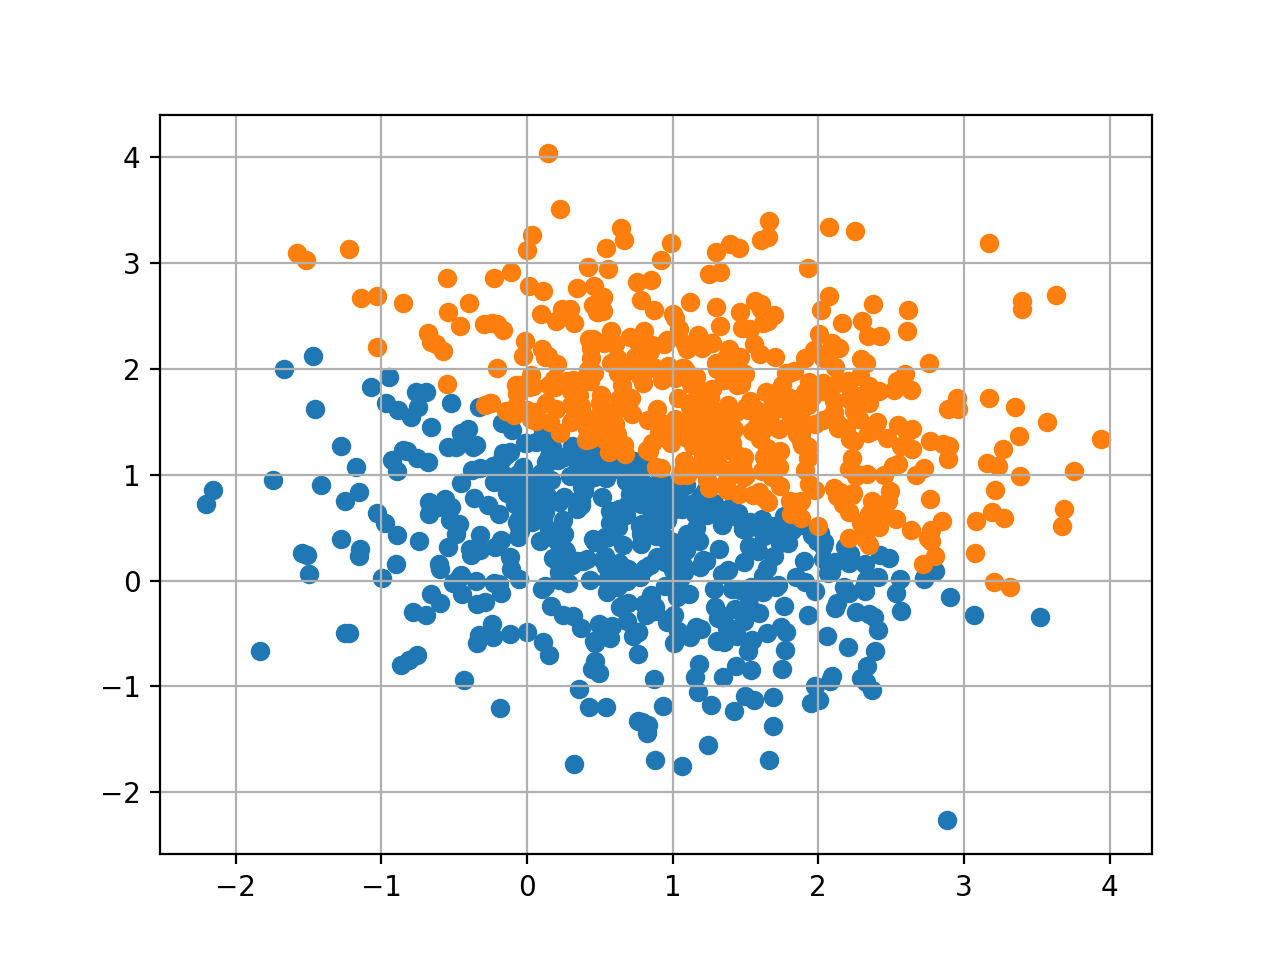

In [8]:
# 2D Check 
samples_x_1 = [x for x,l in zip(samples_xs[:,0], samples_labels) if l==0]
samples_y_1 = [y for y,l in zip(samples_xs[:,1], samples_labels) if l==0]

samples_x_2 = [x for x,l in zip(samples_xs[:,0], samples_labels) if l==1]
samples_y_2 = [y for y,l in zip(samples_xs[:,1], samples_labels) if l==1]


plt.scatter(samples_x_1, samples_y_1)
plt.scatter(samples_x_2, samples_y_2)
plt.grid(True)
plt.show()

In [9]:
# convert data to pytorch format 
tensor_x = torch.Tensor(samples_xs)
tensor_y = torch.Tensor(samples_labels)

my_dataset = torch.utils.data.TensorDataset(tensor_x[:num_samples*4/5],tensor_y[:num_samples*4/5]) # create your dataset
my_test_data = torch.utils.data.TensorDataset(tensor_x[num_samples*4/5:],tensor_y[num_samples*4/5:]) # create your dataset

my_dataloader = torch.utils.data.DataLoader(my_dataset, batch_size=32) # create your dataloader
my_test_dataloader = torch.utils.data.DataLoader(my_test_data) # create your dataloader

In [10]:
# Define a Finite Gaussian Neural Network
class FGNet(nn.Module):
    def __init__(self):
        super(FGNet, self).__init__()
        self.l1 = th.FGN_layer(2,2)

    def forward(self, x):
        x,l = self.l1(x)
        x = F.softmax(x, dim=-1)
        return x,l

In [11]:
# Initialize the network
model = FGNet().to(device)

In [12]:
# model stats
print(model)
print([p.size() for p in list(model.parameters())])
print("Training?", model.training) 

# check sizes
print("l1")
print(model.l1.weights.size()) 
print(model.l1.centers.size()) 
print(model.l1.sigs.size())
print(model.l1.pis.size())

# check weights before training
print("l1")
print(model.state_dict())

FGNet(
  (l1): FGN_layer()
)
[torch.Size([2, 2]), torch.Size([2, 2]), torch.Size([2]), torch.Size([2])]
Training? True
l1
torch.Size([2, 2])
torch.Size([2, 2])
torch.Size([2])
torch.Size([2])
l1
OrderedDict([('l1.weights', tensor([[-0.5509, -0.0780],
        [-1.4037,  1.3576]], device='cuda:0')), ('l1.centers', tensor([[ 2.3907e-05, -4.5113e-03],
        [ 5.0257e-03,  3.7416e-03]], device='cuda:0')), ('l1.sigs', tensor([2.0170, 2.0063], device='cuda:0')), ('l1.pis', tensor([0.5000, 0.5000], device='cuda:0'))])


In [13]:
# importances of the constraints
lmbda = (4.0*0.1/len(my_dataloader.dataset))
print(lmbda)

# loss function
def loss_func(model, output, target):
    
    # split output into pred and likelihoods
    output, likelihood = output
    
    # normal NLL loss
    nll_loss = 1.0*F.nll_loss(output, target.long())
    # sum of sigma squares loss
    sig_loss = 1.0*lmbda*torch.sum(torch.abs(model.l1.sigs)**2)
    # negative log likelihood over gaussian loss
    nllg_loss = 5.0*lmbda*torch.sum(likelihood)
    
    return nll_loss + sig_loss + nllg_loss

0.0005


In [14]:
# number of correct pred function
def pred_func(output, target):
    output,_ = output
    pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    correct = pred.eq(target.long().view_as(pred)).sum().item()
    return correct

In [15]:
# model_optimizer
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01, momentum=0.5, nesterov=True)

In [16]:
epochs = 300
train_res = th.train(model, device, my_dataloader, loss_func, optimizer, epochs, save_hist=2, verbose=True, pred_func=pred_func, test_loader=my_test_dataloader)

Epoch 0 Train set - Average loss: -0.2342, Accuracy: 534/800 (67%)
Test set - Average loss: -0.5329, Accuracy: 128/200 (64%)
Epoch 1 Train set - Average loss: -0.2398, Accuracy: 535/800 (67%)
Test set - Average loss: -0.5367, Accuracy: 129/200 (64%)
Epoch 2 Train set - Average loss: -0.2454, Accuracy: 546/800 (68%)
Test set - Average loss: -0.5405, Accuracy: 135/200 (68%)
Epoch 3 Train set - Average loss: -0.2510, Accuracy: 552/800 (69%)
Test set - Average loss: -0.5444, Accuracy: 137/200 (68%)
Epoch 4 Train set - Average loss: -0.2567, Accuracy: 553/800 (69%)
Test set - Average loss: -0.5483, Accuracy: 138/200 (69%)
Epoch 5 Train set - Average loss: -0.2624, Accuracy: 557/800 (70%)
Test set - Average loss: -0.5522, Accuracy: 138/200 (69%)
Epoch 6 Train set - Average loss: -0.2682, Accuracy: 560/800 (70%)
Test set - Average loss: -0.5561, Accuracy: 139/200 (70%)
Epoch 7 Train set - Average loss: -0.2740, Accuracy: 564/800 (70%)
Test set - Average loss: -0.5601, Accuracy: 140/200 (70%)


Test set - Average loss: -0.7608, Accuracy: 183/200 (92%)
Epoch 66 Train set - Average loss: -0.5430, Accuracy: 735/800 (92%)
Test set - Average loss: -0.7625, Accuracy: 183/200 (92%)
Epoch 67 Train set - Average loss: -0.5451, Accuracy: 737/800 (92%)
Test set - Average loss: -0.7641, Accuracy: 183/200 (92%)
Epoch 68 Train set - Average loss: -0.5471, Accuracy: 738/800 (92%)
Test set - Average loss: -0.7657, Accuracy: 183/200 (92%)
Epoch 69 Train set - Average loss: -0.5491, Accuracy: 739/800 (92%)
Test set - Average loss: -0.7672, Accuracy: 183/200 (92%)
Epoch 70 Train set - Average loss: -0.5510, Accuracy: 741/800 (93%)
Test set - Average loss: -0.7687, Accuracy: 184/200 (92%)
Epoch 71 Train set - Average loss: -0.5529, Accuracy: 741/800 (93%)
Test set - Average loss: -0.7702, Accuracy: 184/200 (92%)
Epoch 72 Train set - Average loss: -0.5548, Accuracy: 742/800 (93%)
Test set - Average loss: -0.7716, Accuracy: 184/200 (92%)
Epoch 73 Train set - Average loss: -0.5566, Accuracy: 742/80

Test set - Average loss: -0.8194, Accuracy: 190/200 (95%)
Epoch 131 Train set - Average loss: -0.6249, Accuracy: 766/800 (96%)
Test set - Average loss: -0.8199, Accuracy: 190/200 (95%)
Epoch 132 Train set - Average loss: -0.6258, Accuracy: 766/800 (96%)
Test set - Average loss: -0.8204, Accuracy: 190/200 (95%)
Epoch 133 Train set - Average loss: -0.6268, Accuracy: 766/800 (96%)
Test set - Average loss: -0.8209, Accuracy: 190/200 (95%)
Epoch 134 Train set - Average loss: -0.6278, Accuracy: 766/800 (96%)
Test set - Average loss: -0.8214, Accuracy: 190/200 (95%)
Epoch 135 Train set - Average loss: -0.6288, Accuracy: 767/800 (96%)
Test set - Average loss: -0.8219, Accuracy: 190/200 (95%)
Epoch 136 Train set - Average loss: -0.6298, Accuracy: 767/800 (96%)
Test set - Average loss: -0.8224, Accuracy: 190/200 (95%)
Epoch 137 Train set - Average loss: -0.6308, Accuracy: 767/800 (96%)
Test set - Average loss: -0.8229, Accuracy: 190/200 (95%)
Epoch 138 Train set - Average loss: -0.6318, Accuracy

Test set - Average loss: -0.8523, Accuracy: 192/200 (96%)
Epoch 196 Train set - Average loss: -0.6857, Accuracy: 772/800 (96%)
Test set - Average loss: -0.8528, Accuracy: 192/200 (96%)
Epoch 197 Train set - Average loss: -0.6865, Accuracy: 773/800 (97%)
Test set - Average loss: -0.8533, Accuracy: 192/200 (96%)
Epoch 198 Train set - Average loss: -0.6872, Accuracy: 773/800 (97%)
Test set - Average loss: -0.8537, Accuracy: 192/200 (96%)
Epoch 199 Train set - Average loss: -0.6879, Accuracy: 773/800 (97%)
Test set - Average loss: -0.8542, Accuracy: 192/200 (96%)
Epoch 200 Train set - Average loss: -0.6886, Accuracy: 773/800 (97%)
Test set - Average loss: -0.8546, Accuracy: 192/200 (96%)
Epoch 201 Train set - Average loss: -0.6892, Accuracy: 773/800 (97%)
Test set - Average loss: -0.8551, Accuracy: 192/200 (96%)
Epoch 202 Train set - Average loss: -0.6899, Accuracy: 773/800 (97%)
Test set - Average loss: -0.8555, Accuracy: 192/200 (96%)
Epoch 203 Train set - Average loss: -0.6906, Accuracy

Test set - Average loss: -0.8747, Accuracy: 196/200 (98%)
Epoch 261 Train set - Average loss: -0.7178, Accuracy: 780/800 (98%)
Test set - Average loss: -0.8749, Accuracy: 196/200 (98%)
Epoch 262 Train set - Average loss: -0.7181, Accuracy: 780/800 (98%)
Test set - Average loss: -0.8752, Accuracy: 196/200 (98%)
Epoch 263 Train set - Average loss: -0.7184, Accuracy: 780/800 (98%)
Test set - Average loss: -0.8754, Accuracy: 196/200 (98%)
Epoch 264 Train set - Average loss: -0.7187, Accuracy: 780/800 (98%)
Test set - Average loss: -0.8756, Accuracy: 196/200 (98%)
Epoch 265 Train set - Average loss: -0.7190, Accuracy: 780/800 (98%)
Test set - Average loss: -0.8759, Accuracy: 196/200 (98%)
Epoch 266 Train set - Average loss: -0.7194, Accuracy: 780/800 (98%)
Test set - Average loss: -0.8761, Accuracy: 196/200 (98%)
Epoch 267 Train set - Average loss: -0.7197, Accuracy: 780/800 (98%)
Test set - Average loss: -0.8763, Accuracy: 196/200 (98%)
Epoch 268 Train set - Average loss: -0.7200, Accuracy

In [17]:
# test model, should be same or close to last line in above cell
th.test(model, device, my_test_dataloader, loss_func, verbose=True, pred_func=pred_func)

Test set - Average loss: -0.8827, Accuracy: 195/200 (98%)


{'test_accuracy': 97.5, 'test_loss': -0.8826734335720539}

In [18]:
# print model state_dict post training
model.state_dict()

OrderedDict([('l1.weights', tensor([[-2.7196, -2.6416],
                      [ 1.7908,  4.7149]], device='cuda:0')),
             ('l1.centers', tensor([[1.0022, 0.9943],
                      [1.0021, 1.0237]], device='cuda:0')),
             ('l1.sigs', tensor([1.0615, 2.8428], device='cuda:0')),
             ('l1.pis', tensor([ 2.0363, -1.0363], device='cuda:0'))])

<IPython.core.display.Javascript object>


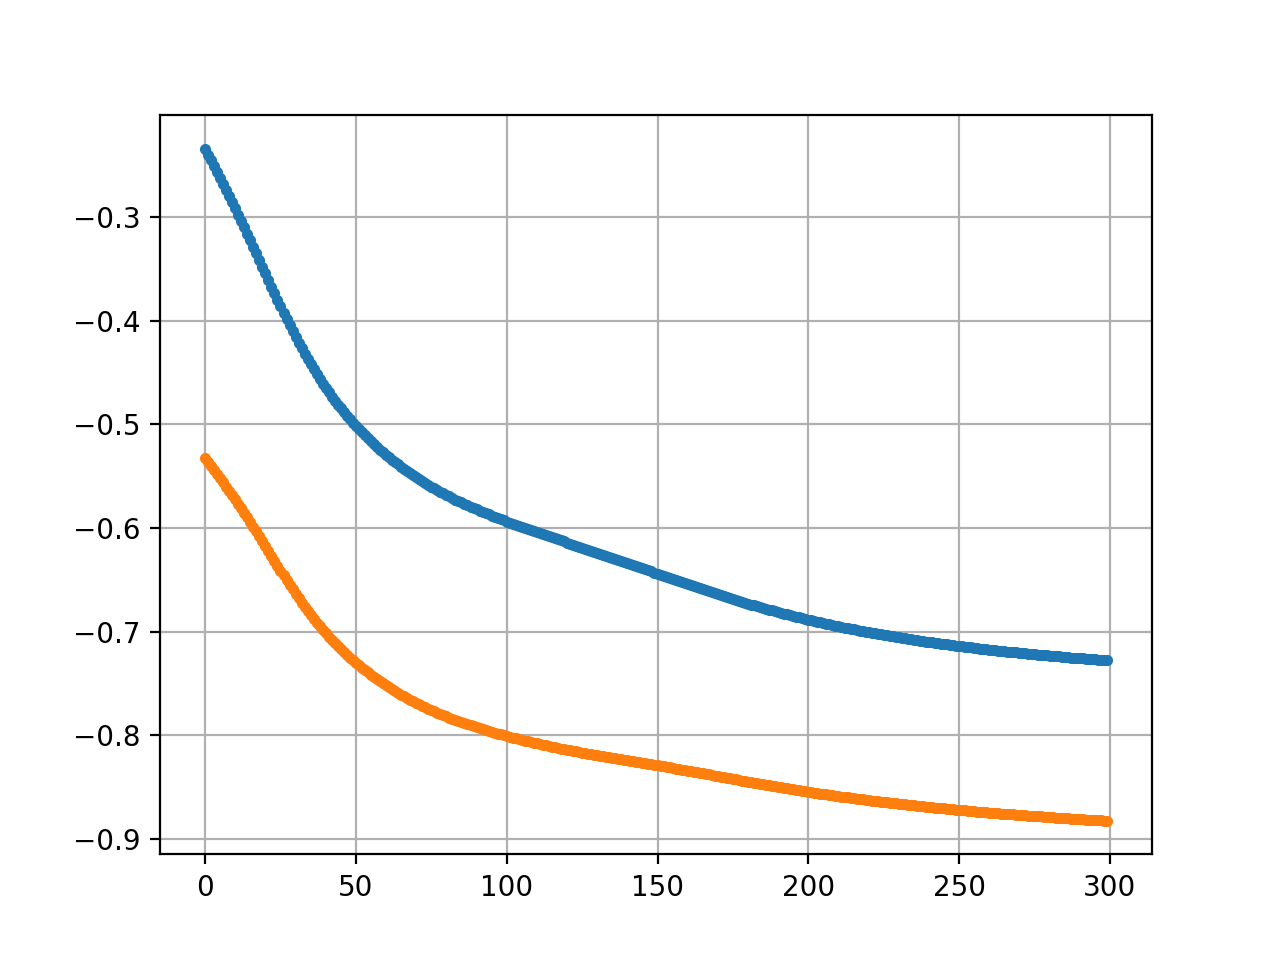

<IPython.core.display.Javascript object>


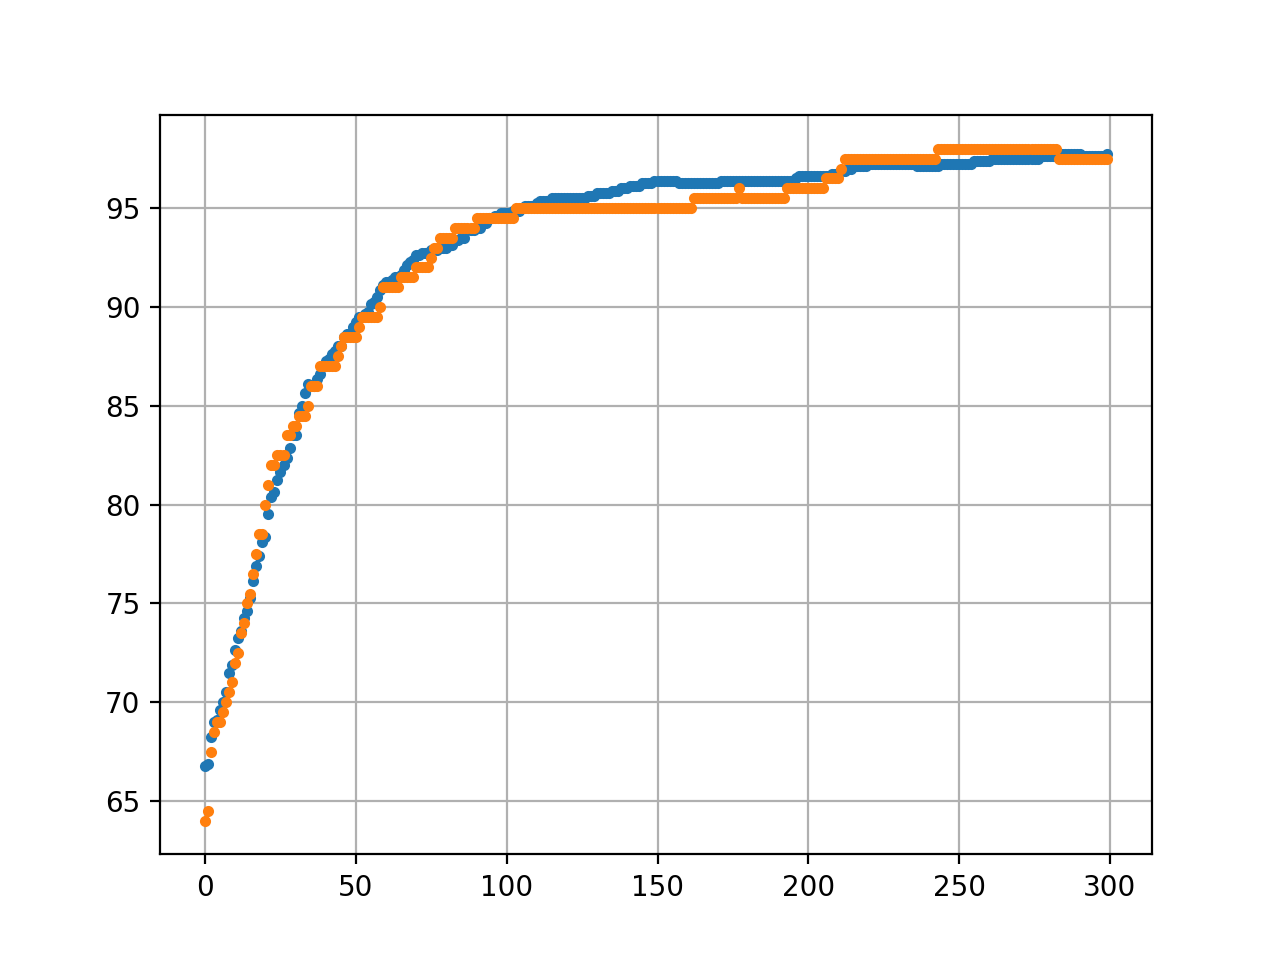

In [19]:
# acc and loss hist
plt.plot(train_res['train_loss_hist'], marker='.', linestyle=' ')
plt.plot(train_res['test_loss_hist'], marker='.', linestyle=' ')
plt.grid()
plt.show()

plt.plot(train_res['train_acc_hist'], marker='.', linestyle=' ')
plt.plot(train_res['test_acc_hist'], marker='.', linestyle=' ')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


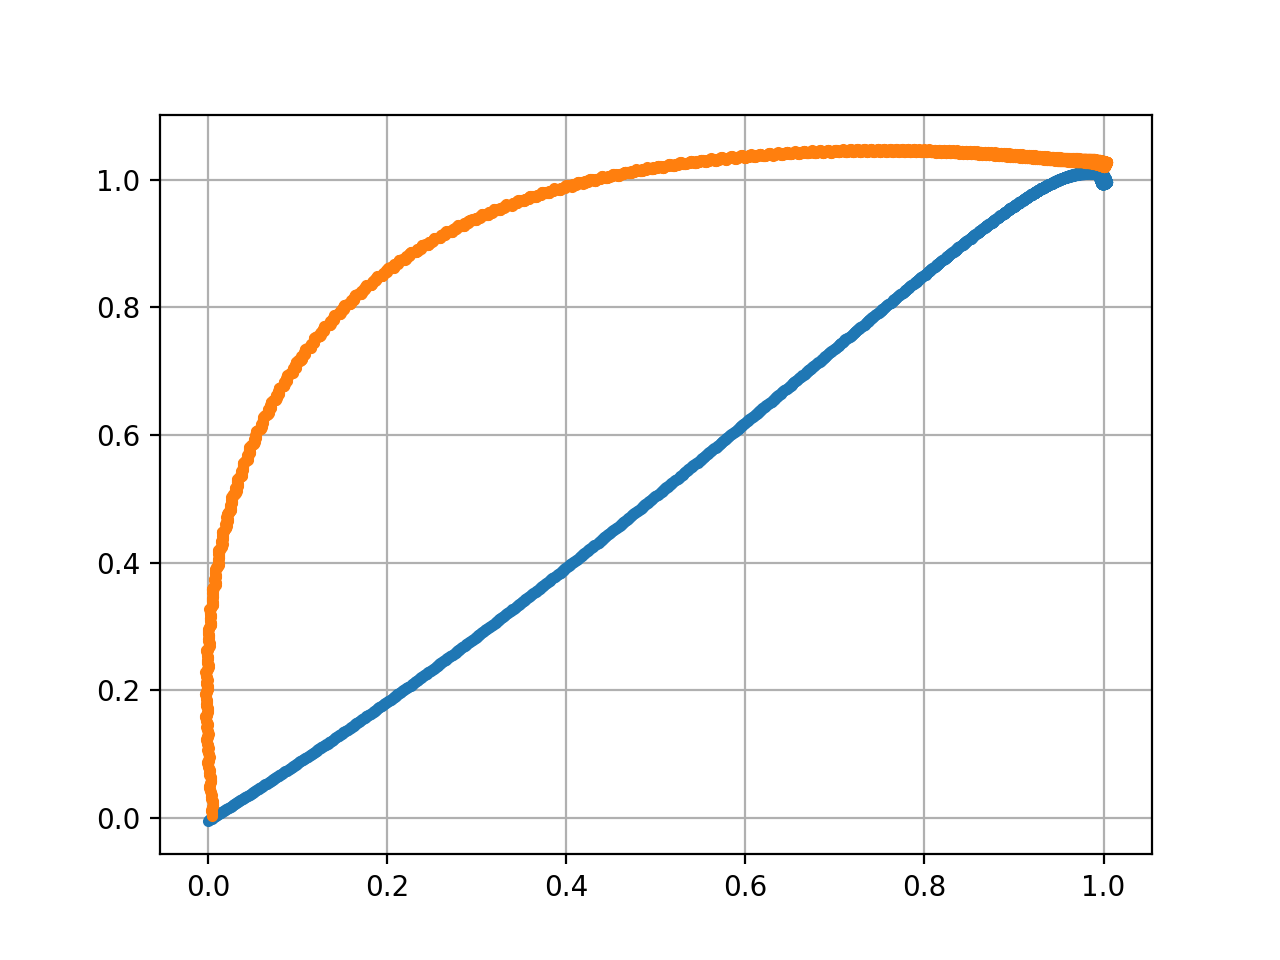

In [20]:
# compare center with target (1,1)
x, y = zip(*train_res['histories']['l1.centers'][:,0,:])
plt.plot(x,y, marker='.', linestyle='-')
x, y = zip(*train_res['histories']['l1.centers'][:,1,:])
plt.plot(x,y, marker='.', linestyle='-')
# plt.axis([-3,3, -3, 3])
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


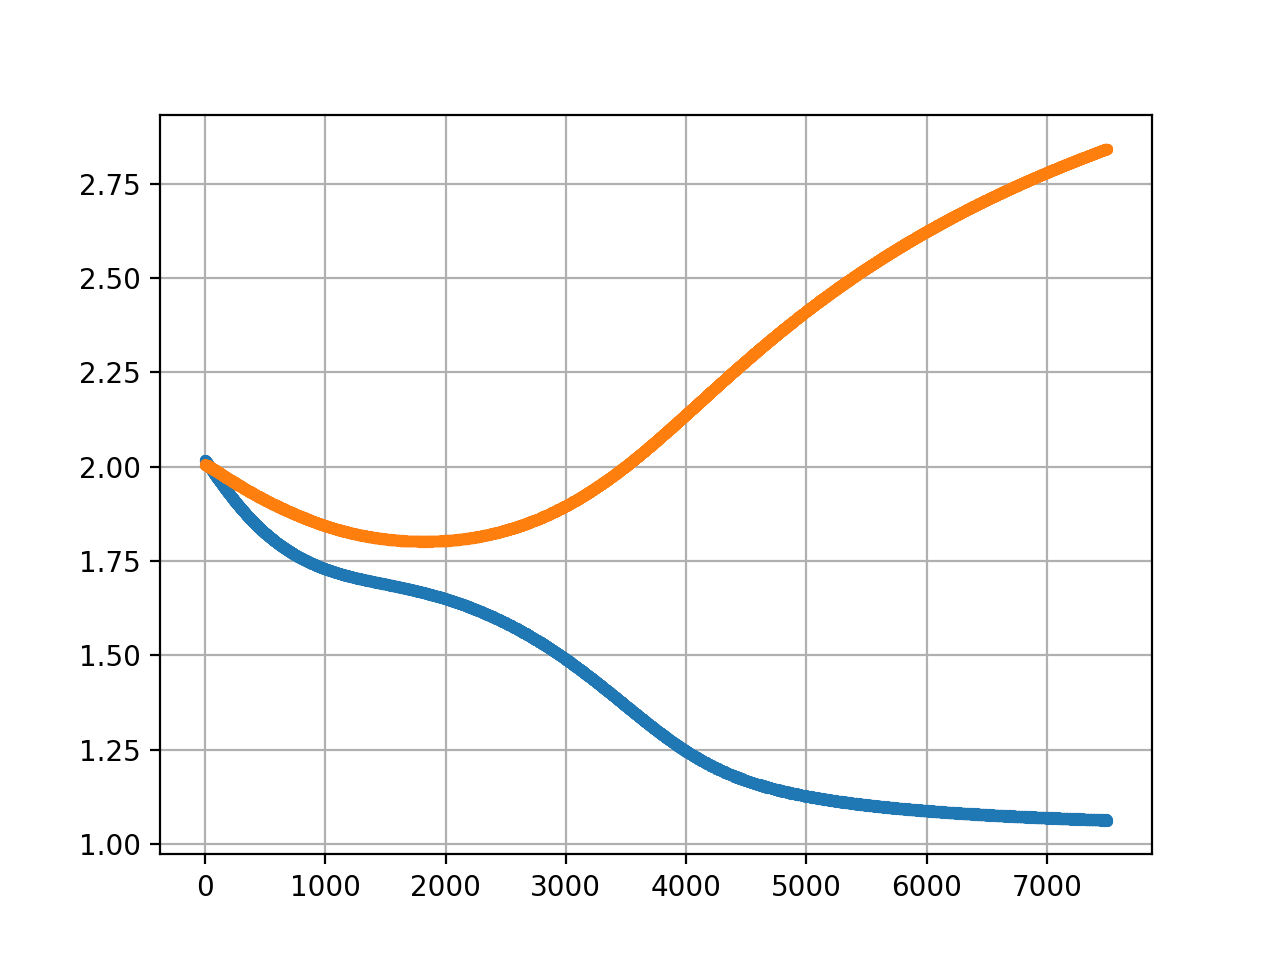

In [21]:
# plot sigma history
plt.plot(train_res['histories']['l1.sigs'][:,0], marker='.', linestyle=' ')
plt.plot(train_res['histories']['l1.sigs'][:,1], marker='.', linestyle=' ')

plt.grid()
plt.show()

In [22]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

<IPython.core.display.Javascript object>


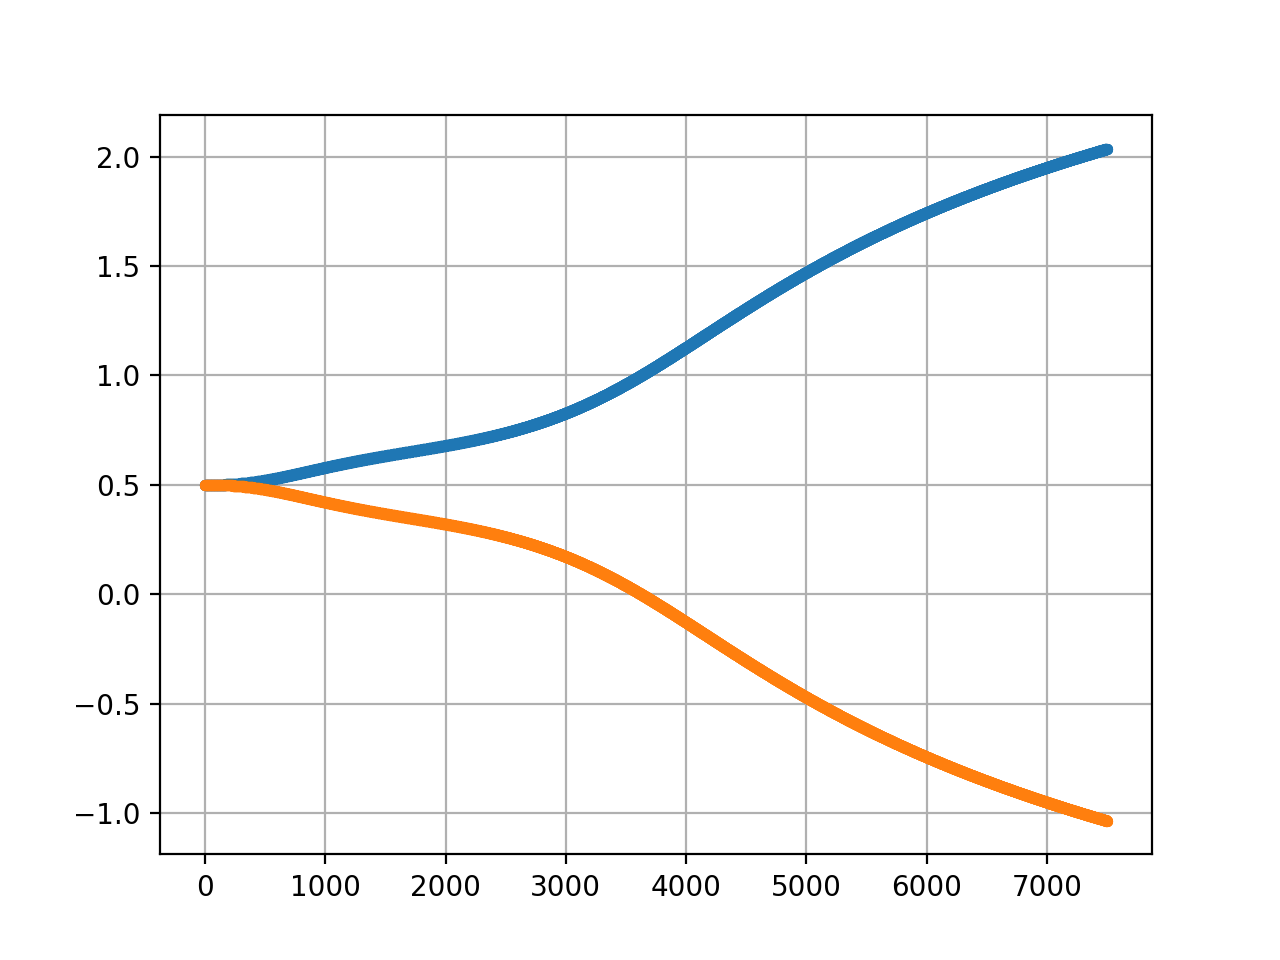

<IPython.core.display.Javascript object>


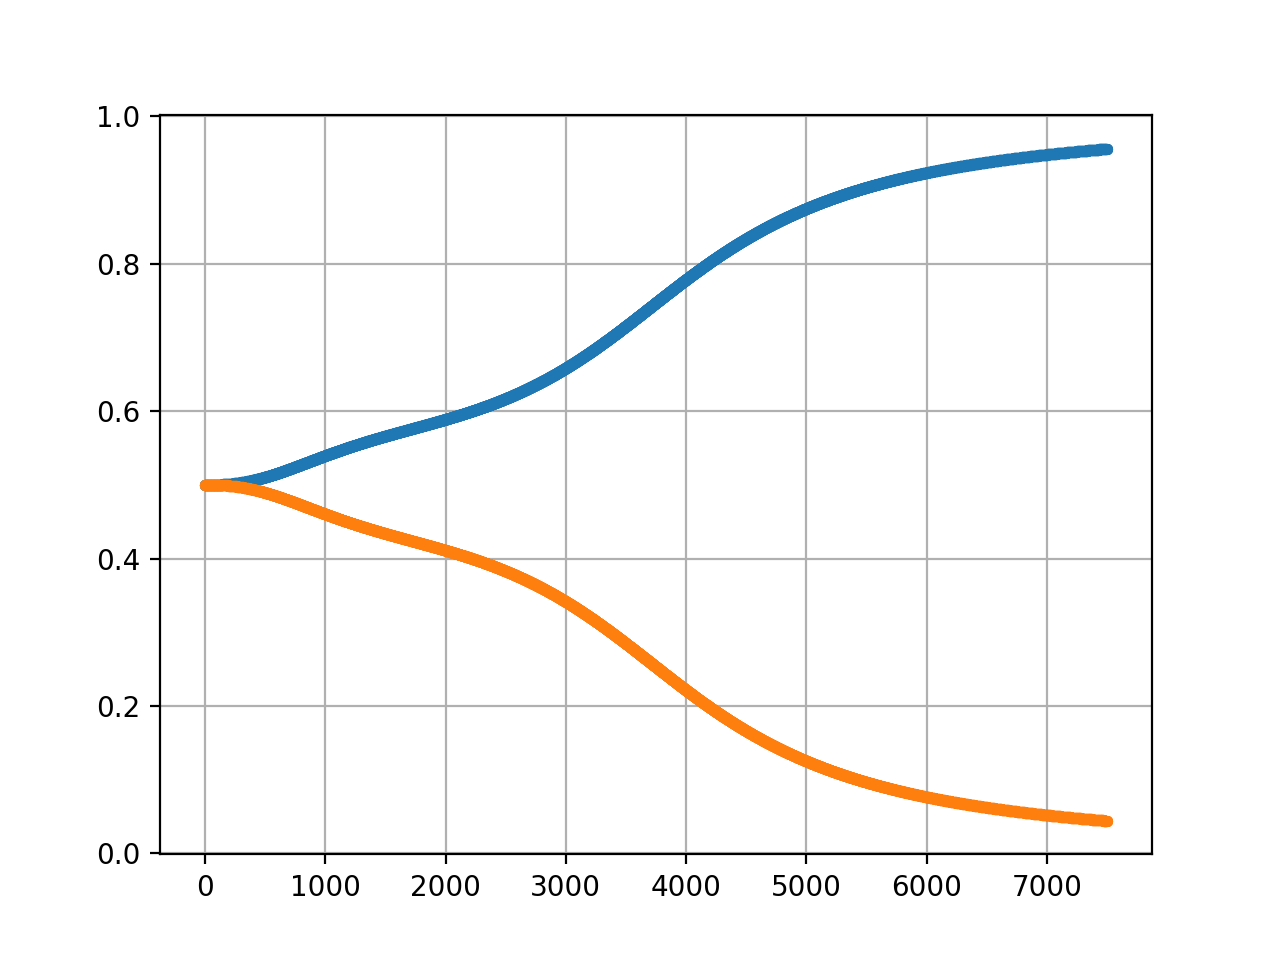

In [23]:
# plot softmax(PIs) history

# unormalized
plt.plot(train_res['histories']['l1.pis'][:,0], marker='.', linestyle=' ')
plt.plot(train_res['histories']['l1.pis'][:,1], marker='.', linestyle=' ')

plt.grid()
plt.show()

#normalized 
normalized_PIs = np.array([softmax(x) for x in train_res['histories']['l1.pis']])
plt.plot(normalized_PIs[:,0], marker='.', linestyle=' ')
plt.plot(normalized_PIs[:,1], marker='.', linestyle=' ')

plt.grid()
plt.show()